# Coffee Disease Classifier

## Overview

Selecting the right set of hyperparameters, variables which controls the performance and topology of the learning model, is at the heart of all machine learning problems. But for long, picking these parameters had been more of an art than a science. Here is where Keras Tuner come in handy. It is hypertuning library which eases the pain of hand picking hyperparameters(say, the number of dense layers, the units per dense layer, whether to use batch normalization or not).

In this notebook, I integrated keras tuner in the workflow for classifying segmented diseased coffee leaf images into five classes(one of which is the health class). At the base of the classifying model is pre-trained CNN achitecture along with the imagenet weights. By using the learned low level features from the pretrained model in our problem, we relieve ourself from the burden of writing the model from scratch. This technique is known as transfer learning.

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. It is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

To nudge the accuracy a little further, I also fine tuned the trained model by unfreezing the some of the layers, with a small learning rate. Finally, the model performance is computed and summarized using confusion matrix and classification reports.

## Setup

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install keras-tuner -q                                     # install keras tuner

     |████████████████████████████████| 135 kB 30.1 MB/s 
     |████████████████████████████████| 1.6 MB 63.0 MB/s 


In [ ]:
!pip install scikit-plot                                        # Install sckit-plot for plotting the confusion matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%load_ext tensorboard
# %reload_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import os
import keras_tuner
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB1, preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB2, preprocess_input
from tensorflow.keras.layers import Input, GlobalMaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler

In [ ]:
train_dir = "/content/drive/MyDrive/CoffeeDiseaseClassifier/CoffeeDeseaseDatasets/train"  # path for the datasets
val_dir = "/content/drive/MyDrive/CoffeeDiseaseClassifier/CoffeeDeseaseDatasets/val"
test_dir = "/content/drive/MyDrive/CoffeeDiseaseClassifier/CoffeeDeseaseDatasets/test"

## Visualizing Data

Found 1905 files belonging to 5 classes.


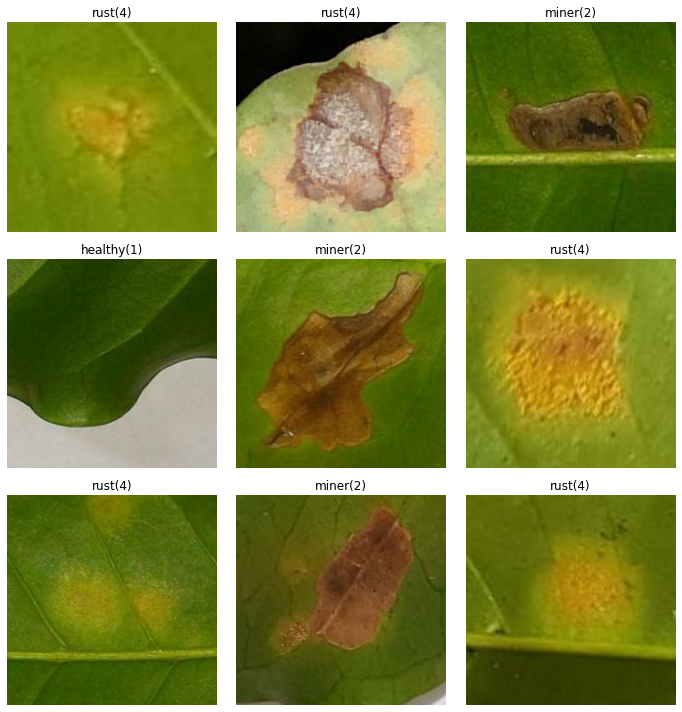

In [ ]:
# draw images from the training dataset(only used for illustration.)
dataset = image_dataset_from_directory(
    directory=train_dir, label_mode="int", shuffle=True, image_size=(256, 256)
)


def stringLabel(num_label):
    labels_dict = dict(
        enumerate(dataset.class_names)
    )  # {0: 'cercospora', 1: 'healthy', 2: 'miner', 3: 'phoma', 4: 'rust'}
    return labels_dict[num_label]


plt.figure(figsize=(10, 10))
for images, labels in dataset.take(
    1
):  # takes batch_size samples from the dataset tensor.
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("{}({})".format(stringLabel(int(labels[i])), int(labels[i])))
        plt.axis("off")
        plt.tight_layout()

## Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
)

val_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
)

test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    shuffle=False,
    class_mode="categorical",
)  # Instantiate test generator to find the exact prediction while running

Found 1905 images belonging to 5 classes.
Found 408 images belonging to 5 classes.
Found 409 images belonging to 5 classes.


### Visualizing Augmented Data

Found 1905 images belonging to 5 classes.


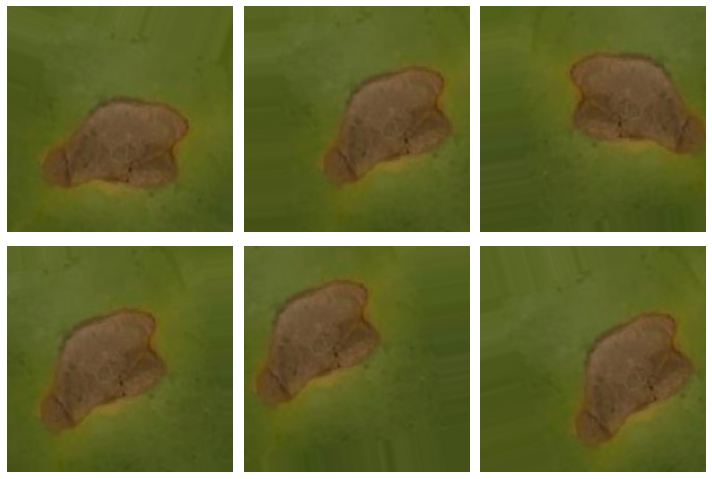

In [ ]:
trial_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(200, 200),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
)  # used only for demonstration

plt.figure(figsize=(10, 7))
for i in range(6):
    image, labels = trial_generator[0]

    plt.subplot(2, 3, i + 1)
    image = np.squeeze(
        image
    )  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image

    plt.imshow(image.astype("uint8"))  # convert to unsigned integers for plotting
    plt.axis("off")
    plt.tight_layout()

## Build the Model

In [ ]:
_EfficientNetB0 = EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3)
)
_EfficientNetB1 = EfficientNetB1(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3)
)
_EfficientNetB2 = EfficientNetB2(
    include_top=False, weights="imagenet", input_shape=(299, 299, 3)
)


# define a function that return a compiled model given the base pretrained model
def buildModel(hp):
    base_model_type = hp.Choice(
        "Base Model", ["EfficientNetB0", "EfficientNetB1", "EfficientNetB2"]
    )

    # Ternary Expression
    base_model = (
        _EfficientNetB0
        if base_model_type == "EfficientNetB0"
        else _EfficientNetB1 if base_model_type == "EfficientNetB1" else _EfficientNetB2
    )
    base_model.trainable = (
        False  # Freeze the pretrained weights so as not to distroy the learned feature
    )

    x = base_model.output

    # Reconstruct the top layers
    x = GlobalMaxPooling2D()(
        x, training=False
    )  # controls whether the layer should run its forward pass in inference mode or training mode
    x = BatchNormalization()(x)

    x = Dense(
        units=hp.Int("Dense Units", min_value=64, max_value=128, step=32),
        activation="relu",
    )(
        x
    )  # Chooses the number of units in a given dense layer

    if hp.Boolean("Batch Norm"):
        x = BatchNormalization()(x)

    x = Dropout(0.2)(x)

    outputs = Dense(5, activation="softmax")(x)  # Same units as the number of classes
    model = Model(inputs=base_model.input, outputs=outputs)

    lr_schedule = ExponentialDecay(
        initial_learning_rate=hp.Float(
            "Initial Learning Rate", min_value=0.006, max_value=0.009, step=0.001
        ),
        decay_steps=118,  # change the learning rate every 2 epoches(118 iterations)
        decay_rate=0.97,
        staircase=True,
    )  # initial_learning_rate * decay_rate ^ (step / decay_steps)
    # If staircase=True, then step / decay_steps is an integer division and follows a staircase function.

    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=lr_schedule),
        metrics=["accuracy"],
    )

    return model

31801344/31790344 [==============================] - 1s 0us/step


In [ ]:
hp = keras_tuner.HyperParameters()
tuner = keras_tuner.RandomSearch(
    hypermodel=buildModel,
    objective="val_accuracy",
    max_trials=50,
    executions_per_trial=1,
    directory="/content/drive/MyDrive/CoffeeDiseaseClassifier/TunerDirectory",
    project_name="TunerSearchResults",
)  # Tuner constructor


tensorboard_dir = (
    "/content/drive/MyDrive/CoffeeDiseaseClassifier/TunerDirectory/TensorboardDirectory"
)
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=4,
    batch_size=32,
    callbacks=[TensorBoard(tensorboard_dir)],
)

Trial 50 Complete [00h 02m 15s]
val_accuracy: 0.8995097875595093

Best val_accuracy So Far: 0.9240196347236633
Total elapsed time: 02h 22m 08s


## Visualizing the Tuning Result

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/CoffeeDiseaseClassifier/TunerDirectory/TensorboardDirectory

In [ ]:
tuner.results_summary(5)

Results summary
Results in /content/drive/MyDrive/CoffeeDiseaseClassifier/TunerDirectory/TunerSearchResults
Showing 5 best trials
Trial summary
Hyperparameters:
Base Model: EfficientNetB1
Dense Units: 96
Batch Norm: True
Initial Learning Rate: 0.007
Score: 0.9240196347236633
Trial summary
Hyperparameters:
Base Model: EfficientNetB0
Dense Units: 128
Batch Norm: True
Initial Learning Rate: 0.008
Score: 0.9215686321258545
Trial summary
Hyperparameters:
Base Model: EfficientNetB0
Dense Units: 96
Batch Norm: True
Initial Learning Rate: 0.007
Score: 0.9215686321258545
Trial summary
Hyperparameters:
Base Model: EfficientNetB1
Dense Units: 64
Batch Norm: False
Initial Learning Rate: 0.008
Score: 0.9191176295280457
Trial summary
Hyperparameters:
Base Model: EfficientNetB0
Dense Units: 128
Batch Norm: True
Initial Learning Rate: 0.006
Score: 0.9191176295280457


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(
    best_hps
)  # build the model using the hyperparameters from the tuner search results.
# model.summary()

## Training the Tuned Model

In [ ]:
num_epochs = 120
check_point = ModelCheckpoint(filepath='/content/drive/MyDrive/CoffeeDiseaseClassifier/Checkpoints/FirstRun',
                              monitor='val_accuracy',
                              verbose=1,
                              save_best_only=True,
                              save_weights_only=True,
                              mode='auto',
                              save_freq='epoch')
early_stop = EarlyStopping(monitor="val_accuracy",
                           min_delta=0.001,
                           patience=15,
                           verbose=1)

hist = model.fit(train_generator,d
                 steps_per_epoch =train_generator.n//train_generator.batch_size,
                 epochs = num_epochs,
                 verbose=2,
                 validation_data = val_generator,
                 validation_steps=val_generator.n//val_generator.batch_size,
                 callbacks = [check_point, early_stop])

Epoch 1/120

Epoch 1: val_accuracy improved from -inf to 0.80990, saving model to /content/drive/MyDrive/CoffeeDiseaseClassifier/Checkpoints/FirstRun
59/59 - 43s - loss: 0.7820 - accuracy: 0.7368 - val_loss: 0.9760 - val_accuracy: 0.8099 - 43s/epoch - 736ms/step
Epoch 2/120

Epoch 2: val_accuracy improved from 0.80990 to 0.89323, saving model to /content/drive/MyDrive/CoffeeDiseaseClassifier/Checkpoints/FirstRun
59/59 - 31s - loss: 0.4404 - accuracy: 0.8430 - val_loss: 0.3949 - val_accuracy: 0.8932 - 31s/epoch - 526ms/step
Epoch 3/120

Epoch 3: val_accuracy did not improve from 0.89323
59/59 - 31s - loss: 0.3879 - accuracy: 0.8574 - val_loss: 0.3528 - val_accuracy: 0.8854 - 31s/epoch - 522ms/step
Epoch 4/120

Epoch 4: val_accuracy improved from 0.89323 to 0.89583, saving model to /content/drive/MyDrive/CoffeeDiseaseClassifier/Checkpoints/FirstRun
59/59 - 31s - loss: 0.3366 - accuracy: 0.8815 - val_loss: 0.3304 - val_accuracy: 0.8958 - 31s/epoch - 528ms/step
Epoch 5/120

Epoch 5: val_ac

## Visualizing the Training Metrics

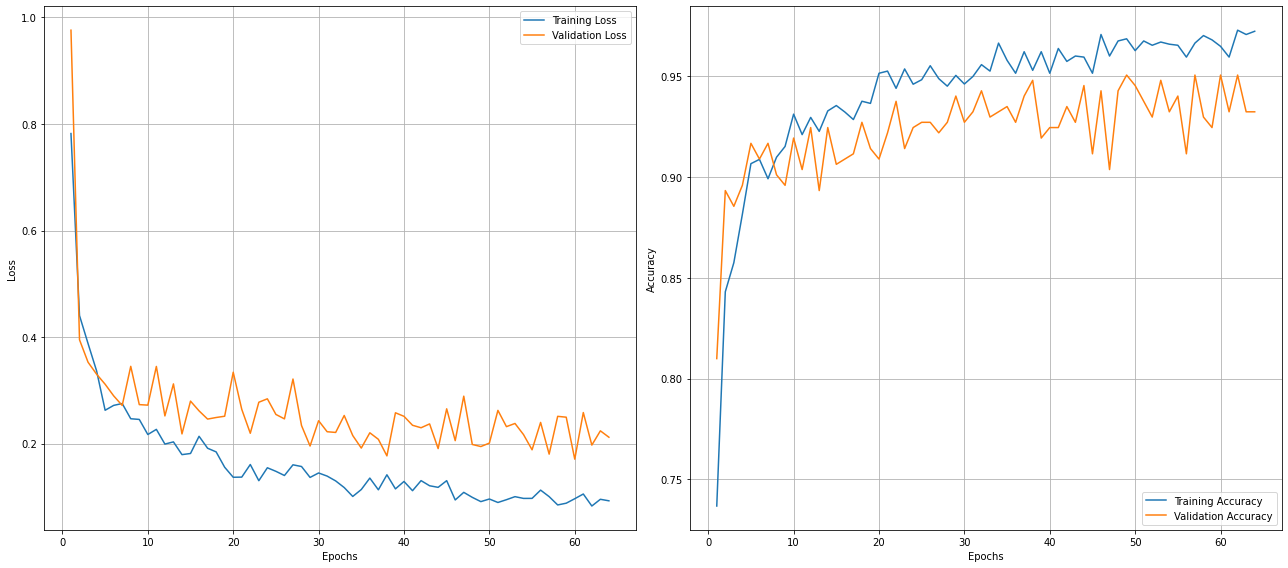

In [ ]:
loss = hist.history["loss"]
accuracy = hist.history["accuracy"]
val_accuracy = hist.history["val_accuracy"]
val_loss = hist.history["val_loss"]
epochs = range(1, 64 + 1)
# epochs       = range(1, num_epochs+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

ax1.plot(epochs, loss, label="Training Loss")
ax1.plot(epochs, val_loss, label="Validation Loss")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epochs")
ax1.legend(loc="upper right")
ax1.grid()

ax2.plot(epochs, accuracy, label="Training Accuracy")
ax2.plot(epochs, val_accuracy, label="Validation Accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epochs")
ax2.legend(loc="lower right")
ax2.grid()


# plt.tight_layout(pad=0.4, w_pad=1, h_pad=1.0)
plt.tight_layout()
plt.show()

## Fine Tuning the Trained Model

Fine-tuning is the process of unfreezing the entire or part of the model and re-training it with a very low learning rate. It is an optional step done to squeeze out the last bit of accuracy from our model.

When we are fine tuning(unfreezing layers), we have leave the BatchNormalization layer frozen. This layer have four weights, two of which are untrainable: the means and variance of the batch. This is done so to keep the weight from being updated during training.



In [ ]:
model.load_weights(
    "/content/drive/MyDrive/CoffeeDiseaseClassifier/Checkpoints/FirstRun"
)  # Load the checkpoint-ed weight with best performance

In [ ]:
for layer in model.layers:
    print(
        f"{layer.trainable}:  {layer.name}"
    )  # see which layers in the model is trainable

False:  input_2
False:  rescaling_1
False:  normalization_1
False:  stem_conv_pad
False:  stem_conv
False:  stem_bn
False:  stem_activation
False:  block1a_dwconv
False:  block1a_bn
False:  block1a_activation
False:  block1a_se_squeeze
False:  block1a_se_reshape
False:  block1a_se_reduce
False:  block1a_se_expand
False:  block1a_se_excite
False:  block1a_project_conv
False:  block1a_project_bn
False:  block1b_dwconv
False:  block1b_bn
False:  block1b_activation
False:  block1b_se_squeeze
False:  block1b_se_reshape
False:  block1b_se_reduce
False:  block1b_se_expand
False:  block1b_se_excite
False:  block1b_project_conv
False:  block1b_project_bn
False:  block1b_drop
False:  block1b_add
False:  block2a_expand_conv
False:  block2a_expand_bn
False:  block2a_expand_activation
False:  block2a_dwconv_pad
False:  block2a_dwconv
False:  block2a_bn
False:  block2a_activation
False:  block2a_se_squeeze
False:  block2a_se_reshape
False:  block2a_se_reduce
False:  block2a_se_expand
False:  block2a

In [ ]:
print(len(model.layers))

345


Unfreeze the layers while leaving the batch normalization layers frozen

In [ ]:
for layer in model.layers[-40:]:  # unfreeze the top  layers
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True
    if isinstance(layer, BatchNormalization) and layer.trainable == True:
        layer.trainable = False

    print(f"{layer.trainable}:  {layer.name}")

False:  block6e_project_bn
True:  block6e_drop
True:  block6e_add
True:  block7a_expand_conv
False:  block7a_expand_bn
True:  block7a_expand_activation
True:  block7a_dwconv
False:  block7a_bn
True:  block7a_activation
True:  block7a_se_squeeze
True:  block7a_se_reshape
True:  block7a_se_reduce
True:  block7a_se_expand
True:  block7a_se_excite
True:  block7a_project_conv
False:  block7a_project_bn
True:  block7b_expand_conv
False:  block7b_expand_bn
True:  block7b_expand_activation
True:  block7b_dwconv
False:  block7b_bn
True:  block7b_activation
True:  block7b_se_squeeze
True:  block7b_se_reshape
True:  block7b_se_reduce
True:  block7b_se_expand
True:  block7b_se_excite
True:  block7b_project_conv
False:  block7b_project_bn
True:  block7b_drop
True:  block7b_add
True:  top_conv
False:  top_bn
True:  top_activation
True:  global_max_pooling2d_1
False:  batch_normalization_2
True:  dense_2
False:  batch_normalization_3
True:  dropout_1
True:  dense_3


In [ ]:
num_epochs = 70
tune_check_point = ModelCheckpoint(
    filepath="/content/drive/MyDrive/CoffeeDiseaseClassifier/Checkpoints/FineTuned",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
)

early_stop = EarlyStopping(
    monitor="val_accuracy", min_delta=0.001, patience=20, verbose=1
)


lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-04, decay_steps=118, decay_rate=0.97, staircase=True
)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),  # use small learning rate
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

tuned_hist = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=num_epochs,
    verbose=2,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[tune_check_point, early_stop],
)

model.save("/content/drive/MyDrive/CoffeeDiseaseClassifier/BestModel")

Epoch 1/70

Epoch 1: val_accuracy improved from -inf to 0.96354, saving model to /content/drive/MyDrive/CoffeeDiseaseClassifier/Checkpoints/FineTuned
59/59 - 46s - loss: 0.0560 - accuracy: 0.9818 - val_loss: 0.1599 - val_accuracy: 0.9635 - 46s/epoch - 783ms/step
Epoch 2/70

Epoch 2: val_accuracy did not improve from 0.96354
59/59 - 31s - loss: 0.0404 - accuracy: 0.9861 - val_loss: 0.2129 - val_accuracy: 0.9401 - 31s/epoch - 528ms/step
Epoch 3/70

Epoch 3: val_accuracy did not improve from 0.96354
59/59 - 38s - loss: 0.0439 - accuracy: 0.9872 - val_loss: 0.1938 - val_accuracy: 0.9453 - 38s/epoch - 644ms/step
Epoch 4/70

Epoch 4: val_accuracy did not improve from 0.96354
59/59 - 31s - loss: 0.0364 - accuracy: 0.9888 - val_loss: 0.1849 - val_accuracy: 0.9427 - 31s/epoch - 532ms/step
Epoch 5/70

Epoch 5: val_accuracy did not improve from 0.96354
59/59 - 31s - loss: 0.0284 - accuracy: 0.9883 - val_loss: 0.2067 - val_accuracy: 0.9531 - 31s/epoch - 530ms/step
Epoch 6/70

Epoch 6: val_accuracy

##Visualizing the Fined Tuned Model

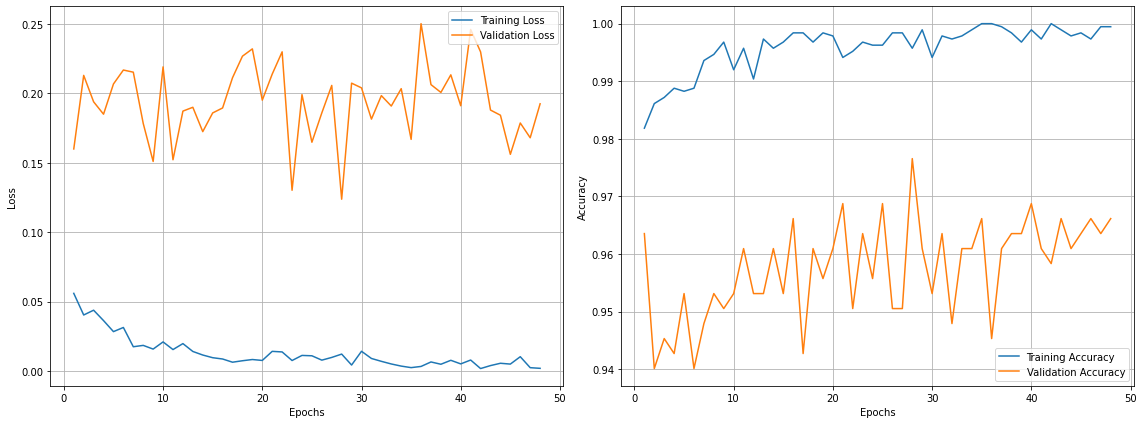

In [ ]:
loss = tuned_hist.history["loss"]
accuracy = tuned_hist.history["accuracy"]
val_accuracy = tuned_hist.history["val_accuracy"]
val_loss = tuned_hist.history["val_loss"]
epochs = range(1, 48 + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, loss, label="Training Loss")
ax1.plot(epochs, val_loss, label="Validation Loss")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epochs")
ax1.legend(loc="upper right")
ax1.grid()

ax2.plot(epochs, accuracy, label="Training Accuracy")
ax2.plot(epochs, val_accuracy, label="Validation Accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epochs")
ax2.legend(loc="lower right")
ax2.grid()

# plt.tight_layout(pad=0.4, w_pad=1, h_pad=1.0)
plt.tight_layout()
plt.show()

## Prediction and Results

In [ ]:
model.load_weights(
    "/content/drive/MyDrive/CoffeeDiseaseClassifier/Checkpoints/FineTuned"
)

In [ ]:
loss, acc = model.evaluate(test_generator, verbose=0)
print("    Test Loss: {:.5f}".format(loss))
print("Test Accuracy: {:.2f}%".format(acc * 100))

    Test Loss: 0.28400
Test Accuracy: 95.35%


In [ ]:
test_generator.reset()
true_labels = test_generator.classes

predicted_probs = model.predict_generator(
    test_generator, steps=test_generator.n // test_generator.batch_size, verbose=0
)  # Return the predicted probabilities for each class, the max value of which is taken


predicted_labels = []
for probs in predicted_probs:
    predicted_labels.append(
        int(np.argmax(probs))
    )  # Chooses the max of the probability values and label encode it.
# predicted_labels = np.array(predicted_labels)                       # convert list to label encoded numpy array

string_labels = test_generator.class_indices
string_labels = dict((v, k) for k, v in string_labels.items())
true_labels = [string_labels[k] for k in true_labels]
predicted_labels = [string_labels[k] for k in predicted_labels]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


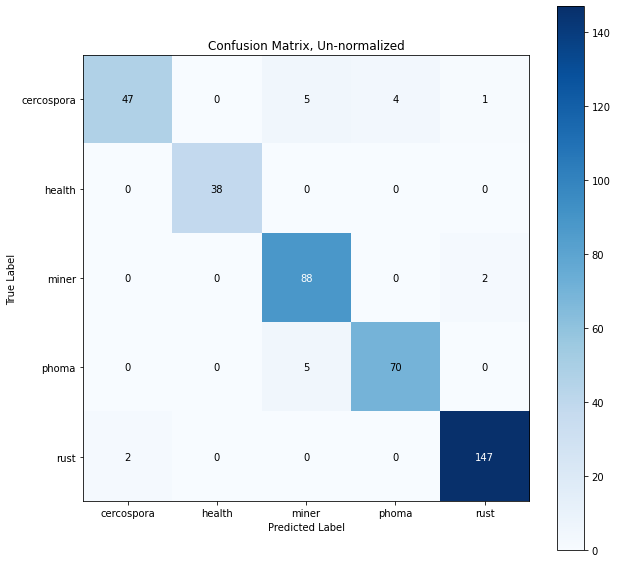

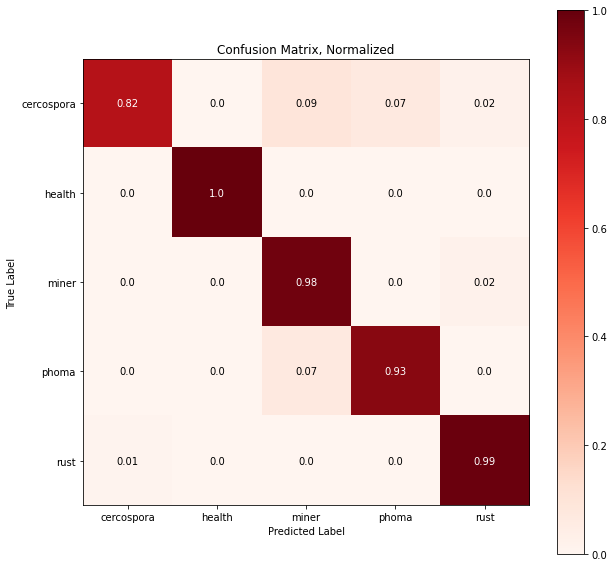

{'cercospora': 0, 'health': 1, 'miner': 2, 'phoma': 3, 'rust': 4}


In [ ]:
unnormalized = plot_confusion_matrix(
    true_labels, predicted_labels, normalize=None, cmap="Blues", figsize=(10, 10)
)
unnormalized.set_ylabel("True Label")
unnormalized.set_xlabel("Predicted Label")
unnormalized.title.set_text("Confusion Matrix, Un-normalized")

normalized = plot_confusion_matrix(
    true_labels, predicted_labels, normalize="all", cmap="Reds", figsize=(10, 10)
)
normalized.set_ylabel("True Label")
normalized.set_xlabel("Predicted Label")
normalized.title.set_text("Confusion Matrix, Normalized")

plt.show()

print(test_generator.class_indices)

In [ ]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

  cercospora       0.96      0.82      0.89        57
      health       1.00      1.00      1.00        38
       miner       0.90      0.98      0.94        90
       phoma       0.95      0.93      0.94        75
        rust       0.98      0.99      0.98       149

    accuracy                           0.95       409
   macro avg       0.96      0.94      0.95       409
weighted avg       0.95      0.95      0.95       409



## References



*   [Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/)
*   [Image classification via fine-tuning with EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)

* [Visualize the hyperparameter tuning process](https://keras.io/guides/keras_tuner/visualize_tuning/)
* [Getting started with KerasTuner](https://keras.io/guides/keras_tuner/getting_started/)
* [Introduction to the Keras Tuner](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/keras_tuner.ipynb#scrollTo=Tce3stUlHN0L)